In [2]:
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import h5py as h5
import time
log_file = 'io/MAML_pipe_log_2976_hist.log'

## Test loading and time

In [3]:
# seed = 14
# n_tasks = 190
# n_samples = 500
# trainfile = '/exafs/400NVX2/cmacmahon/spectra_data/cl_ee_200tasks_5000samples_seed456.h5'
# np.random.seed(seed)
# torch.manual_seed(seed)

# task_inds = np.random.choice(200, n_tasks+1, replace=False)
# sample_inds = np.random.choice(5000, n_samples, replace=False)
# # sort the indices
# task_inds.sort()

# print('Loading training data...')
# # Load the training data and split into train and validation sets
# #### I/O KEY READ POINT ####
# start = time.time()
# with h5.File(trainfile, 'r') as f:
#     X_train = f['X_train'][task_inds[:-1]]
#     y_train = f['y_train'][task_inds[:-1]]
#     X_val = f['X_train'][task_inds[-1]]
#     y_val = f['y_train'][task_inds[-1]]
# load_time = time.time() - start
# print('Loading training data took', load_time, 'seconds')

# X_train_volume = X_train.nbytes
# y_train_volume = y_train.nbytes
# X_val_volume = X_val.nbytes
# y_val_volume = y_val.nbytes

# total_volume = X_train_volume + y_train_volume + X_val_volume + y_val_volume
# print(f"Total loaded volume: {total_volume / 1e9:.2f} GB")

# # estimate bandwidth
# bandwidth = total_volume / load_time
# print(f"Estimated bandwidth: {bandwidth / 1e9:.2f} GB/s")

In [4]:
# # Load full file and resave as NPZ
# with h5.File(trainfile, 'r') as f:
#     keys = list(f.keys())
#     # Create a dictionary to hold the data
#     data_dict = {}
#     # Iterate over the keys and read the data into the dictionary
#     for key in keys:
#         data_dict[key] = f[key][:]

# # Save the data as a .npz file
# npz_name = '/exafs/400NVX2/cmacmahon/spectra_data/cl_ee_200tasks_5000samples_seed456.npz'
# np.savez_compressed(npz_name, **data_dict)

In [5]:
# # test loading from NPZ
# start = time.time()
# with np.load(npz_name) as data:
#     X_train = data['X_train'][task_inds[:-1]]
#     y_train = data['y_train'][task_inds[:-1]]
#     X_val = data['X_train'][task_inds[-1]]
#     y_val = data['y_train'][task_inds[-1]]
# load_time = time.time() - start
# print('Loading training data from NPZ took', load_time, 'seconds')
# X_train_volume = X_train.nbytes
# y_train_volume = y_train.nbytes
# X_val_volume = X_val.nbytes
# y_val_volume = y_val.nbytes
# total_volume = X_train_volume + y_train_volume + X_val_volume + y_val_volume
# print(f"Total loaded volume: {total_volume / 1e9:.2f} GB")

# # estimate bandwidth
# bandwidth = total_volume / load_time
# print(f"Estimated bandwidth: {bandwidth / 1e9:.2f} GB/s")

In [6]:
def parse_log_as_dict(filepath):
    with open(filepath, 'r') as f:
        text = f.read()

    # Split the log into blocks based on the separator
    blocks = re.split(r'\n\.\.\.\n', text.strip())
    data = []

    # Iterate through each block and extract relevant information
    for block in blocks:
        entry = {}

        # Extract metadata
        entry['timestamp'] = int(re.search(r'timestamp:\s+(\d+)', block).group(1))
        entry['servers_queried'] = int(re.search(r'servers_queried:\s+(\d+)', block).group(1))
        entry['osts_queried'] = int(re.search(r'osts_queried:\s+(\d+)', block).group(1))
        entry['mdts_queried'] = int(re.search(r'mdts_queried:\s+(\d+)', block).group(1))
        entry['total_jobs'] = int(re.search(r'total_jobs:\s+(\d+)', block).group(1))

        # Extract job block (first job only, assuming just one)
        job_match = re.search(r'- "(.*?)":\{(.*)\}\s*$', block, re.DOTALL)
        if job_match:
            job_body = job_match.group(2)

            # Fix syntax to make it Python-eval-friendly
            job_body = re.sub(r"(\w+):", r"'\1':", job_body)  # quote keys
            job_body = re.sub(r"'(\w+)'\s*:", r"'\1':", job_body)  # fix nested too

            try:
                # Convert string to python dict
                job_dict = ast.literal_eval("{" + job_body + "}")
                # Flatten nested 'rb' and 'wb'
                for k, v in job_dict.items():
                    if isinstance(v, dict):
                        for subk, subv in v.items():
                            entry[f"{k}_{subk}"] = subv
                    else:
                        entry[k] = v
            except Exception as e:
                print(f"Could not parse job dict: {e}")
                continue

        data.append(entry)

    df = pd.DataFrame(data)
    df['runtime'] = df['timestamp'] - df['timestamp'].iloc[0]
    df = df.drop(columns=['timestamp'])
    
    #Convert NaN values to 0
    df = df.fillna(0)
    
    return df

In [7]:
df = parse_log_as_dict(log_file)
print(df.columns)

Index(['servers_queried', 'osts_queried', 'mdts_queried', 'total_jobs', 'ops',
       'op', 'ga', 'rd', 'rb_4K', 'rb_512K', 'rb_1M', 'rb_16M', 'rb_4M', 'cl',
       'sa', 'gx', 'pu', 'wr', 'wb_16M', 'mn', 'ul', 'rb_1', 'wb_4K', 'wb_4M',
       'wb_2M', 'runtime'],
      dtype='object')


In [8]:
def reconstruct_cumulative(series):
    """
    Reconstruct cumulative values from a series, resetting the total
    when a decrease is detected.
    """
    # Initialize cumulative list and total
    cumulative = []
    total = 0
    prev = series.iloc[0] # Start with the first value

    for val in series:
        delta = val - prev # Calculate the difference from the previous value
        if delta < 0:
            # Reset detected
            total += 0  # don't add anything, assume restart
        else:
            total += delta # Add the delta to the total
        cumulative.append(total)
        prev = val

    return pd.Series(cumulative, index=series.index)

# Map of block type to size in bytes
size_map = {
    '4K': 4 * 1024,
    '512K': 512 * 1024,
    '1M': 1 * 1024 ** 2,
    '2M': 2 * 1024 ** 2,
    '4M': 4 * 1024 ** 2,
    '16M': 16 * 1024 ** 2,
    '1': 1  # in case something odd slipped in
}

def compute_total_bytes(df, size_map, prefix):
    """
    Compute the total bytes for a given prefix in the DataFrame.
    """
    # Initialize a Series to hold the total bytes
    total_bytes = pd.Series(0, index=df.index)

    # Iterate through the columns that start with the prefix
    for col in df.columns:
        if col.startswith(prefix):
            block = col.split('_')[1] # Extract the block type
            if len(block) > 1:
                size = size_map.get(block, 0) # Get the size from the map
                total_bytes += df[col].fillna(0) * size # Multiply by the size

    return total_bytes

In [9]:
# Reconstruct cumulative values for read/write operations
for col in df.columns:
    if col.startswith('rb_') or col.startswith('wb_'):
        # Reconstruct cumulative values for read/write operations
        df[col] = reconstruct_cumulative(df[col])

# Compute total I/O in Bytes
df['rd_totb'] = compute_total_bytes(df, size_map=size_map, prefix='rb')
df['wr_totb'] = compute_total_bytes(df, size_map=size_map, prefix='wb')

# Labels in log file for different operations
operations_metadata_labels = ['cr', 'op', 'cl', 'mn', 'ln', 'ul', 'mk', 'rm', 'mv',
                'ga', 'sa', 'gx', 'sx', 'st', 'sy', 'pu', 'mi', 'fa', 
                'dt', 'gi', 'si', 'qc', 'pa']

# Map of operations to their full names
operations_metadata_full_names = ['create', 'open', 'close', 'mknod', 'link', 'unlink', 'mkdir', 
    'rmdir', 'rename', 'getattr', 'setattr', 'getxattr', 'setxattr', 
    'statfs', 'sync', 'punch', 'migrate', 'fallocate', 
    'destroy', 'get_info', 'set_info', 'quotactl', 'prealloc', 
]

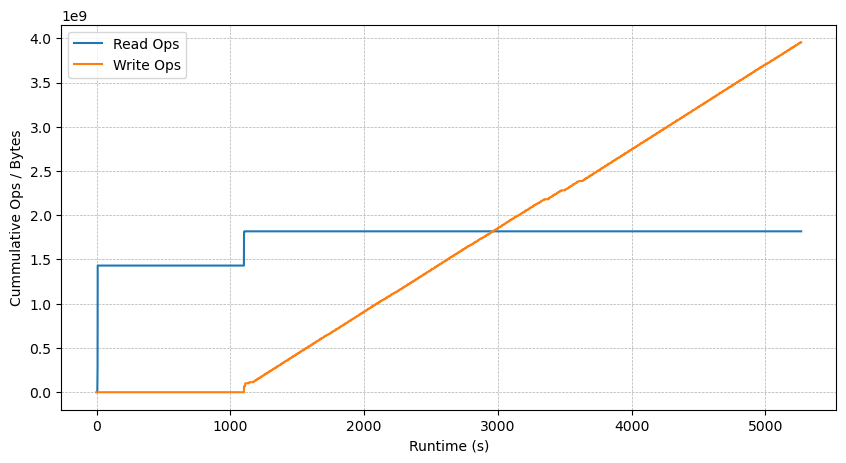

In [10]:
plt.figure(figsize=(10, 5))
# add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.plot(df['runtime'], df['rd_totb'], label='Read Ops')
plt.plot(df['runtime'], df['wr_totb'], label='Write Ops')
plt.xlabel('Runtime (s)')
plt.ylabel('Cummulative Ops / Bytes')
plt.legend()
plt.savefig('MAML_total_read_write.png')

In [11]:
# Print total read and write bytes
total_rd_bytes = df['rd_totb'].iloc[-1]
total_wr_bytes = df['wr_totb'].iloc[-1]
print(f"Total Read Bytes: {total_rd_bytes / 1e9:.2f} GB")
print(f"Total Write Bytes: {total_wr_bytes / 1e9:.2f} GB")
print(f"Total Read + Write Bytes: {(total_rd_bytes + total_wr_bytes) / 1e9:.2f} GB")

Total Read Bytes: 1.82 GB
Total Write Bytes: 3.96 GB
Total Read + Write Bytes: 5.77 GB


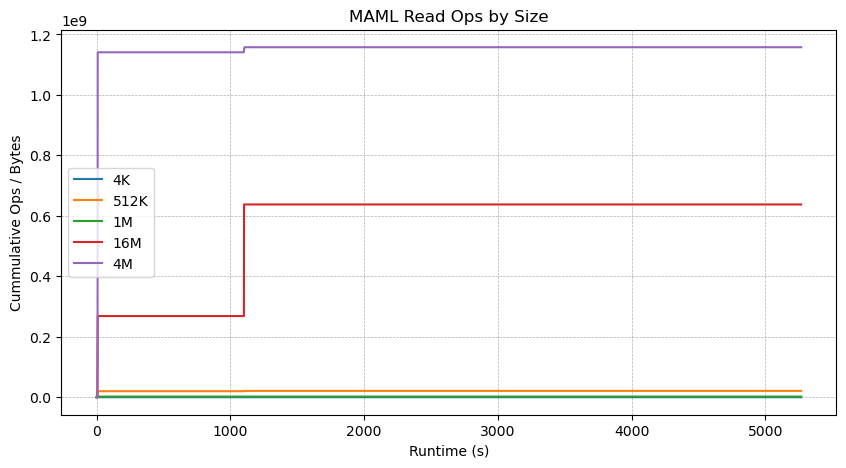

In [12]:
# Plot ops by size
plt.figure(figsize=(10, 5))
# add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
for col in df.columns:
    if col.startswith('rb'):
        block = col.split('_')[1]
        if len(block) > 1:
            size = size_map.get(block, 0)
            # convert to bytes
            ops_size = df[col] * size
            plt.plot(df['runtime'], ops_size, label=f'{block}')
plt.xlabel('Runtime (s)')
plt.ylabel('Cummulative Ops / Bytes')
plt.legend()
plt.title('MAML Read Ops by Size')
plt.savefig('MAML_read_ops_by_size.png')

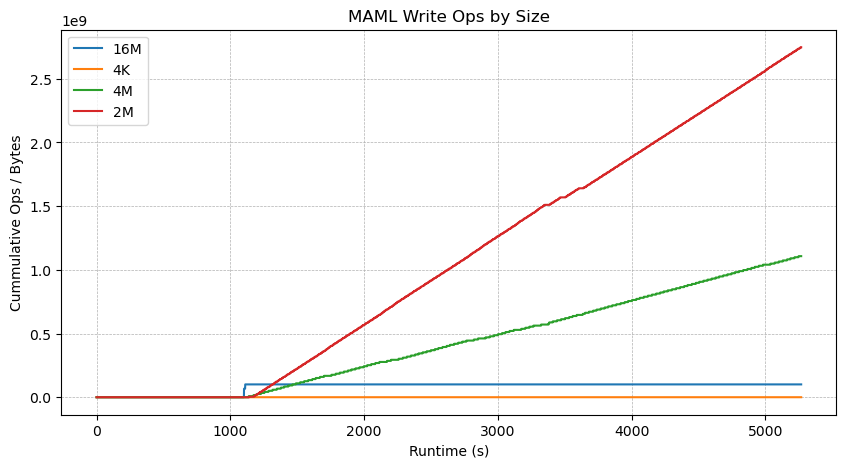

In [13]:
# plot write ops by size
plt.figure(figsize=(10, 5))
# add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
for col in df.columns:
    if col.startswith('wb'):
        block = col.split('_')[1]
        if len(block) > 1:
            size = size_map.get(block, 0)
            # convert to bytes
            ops_size = df[col] * size
            plt.plot(df['runtime'], ops_size, label=f'{block}')
plt.xlabel('Runtime (s)')
plt.ylabel('Cummulative Ops / Bytes')
plt.legend()
plt.title('MAML Write Ops by Size')
plt.savefig('MAML_write_ops_by_size.png')

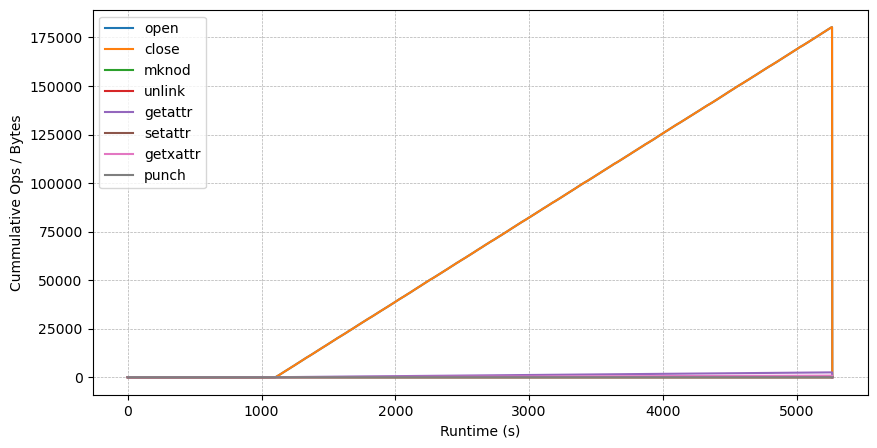

In [14]:
# print cummulative ops by metadata op
plt.figure(figsize=(10, 5))
# add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
for i, op in enumerate(operations_metadata_labels):
    if op in df.columns:
        plt.plot(df['runtime'], df[f'{op}'], label=operations_metadata_full_names[i])
plt.xlabel('Runtime (s)')
plt.ylabel('Cummulative Ops / Bytes')
plt.legend()

In [15]:
def compute_total_per_block(df, size_map, io_type='rb'):
    """
    Plot total I/O volume (in GB) by block size for a given operation type.

    Parameters:
    - df: pandas DataFrame with rb_* or wb_* columns.
    - io_type: 'rb' for read bytes or 'wb' for write bytes.
    """
    io_totals_gb = {}

    for col in df.columns:
        if col.startswith(f'{io_type}_'):
            block = col[len(io_type) + 1:]
            if block in size_map:
                bytes_total = df[col].iloc[-1] * size_map[block]
                io_totals_gb[block] = bytes_total

    # Sort blocks by actual size
    block_order = sorted(io_totals_gb, key=lambda b: size_map[b])
    values = [io_totals_gb[b] for b in block_order]

    return block_order, values

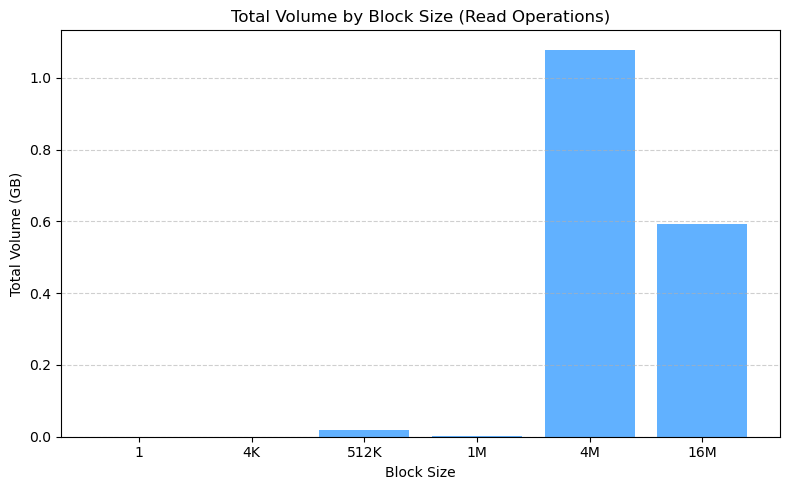

In [16]:
rd_blocks, rd_values = compute_total_per_block(df, size_map, io_type='rb')
# Convert to GB
rd_values = [v / (1024 ** 3) for v in rd_values]
rd_totb = df['rd_totb'].iloc[-1] / (1024 ** 3)

# Check total of each block size matches total I/O computed earlier
assert abs(sum(rd_values) - rd_totb) < 1e-5, f"Total read bytes mismatch: {sum(rd_values)} vs {rd_totb}"

# Plot
plt.figure(figsize=(8, 5))
plt.bar(rd_blocks, rd_values, color='dodgerblue', alpha=0.7)
plt.xlabel("Block Size")
plt.ylabel("Total Volume (GB)")
plt.title("Total Volume by Block Size (Read Operations)")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('read_volume_by_block_size.png')

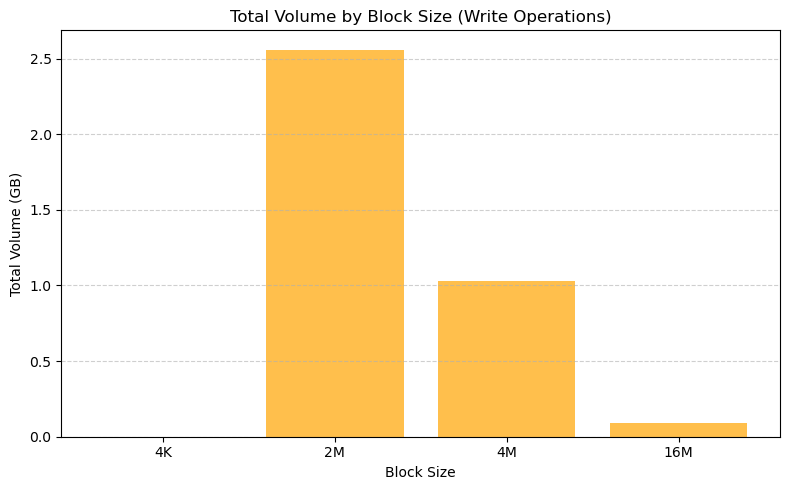

In [17]:
wr_blocks, wr_values = compute_total_per_block(df, size_map, io_type='wb')
# Convert to GB
wr_values = [v / (1024 ** 3) for v in wr_values]
wr_totb = df['wr_totb'].iloc[-1] / (1024 ** 3)

# Check total of each block size matches total I/O computed earlier
assert abs(sum(wr_values) - wr_totb) < 1e-5, f"Total write bytes mismatch: {sum(wr_values)} vs {wr_totb}"
# Plot
plt.figure(figsize=(8, 5))
plt.bar(wr_blocks, wr_values, color='orange', alpha=0.7)
plt.xlabel("Block Size")
plt.ylabel("Total Volume (GB)")
plt.title("Total Volume by Block Size (Write Operations)")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('write_volume_by_block_size.png')

## Bandwidth of Initial Read

## Time spent in I/O

## Perform Analysis of the Rate Logs